# Simplification of roundabouts

Analysis using street network can be sensitive to the actual geometry representation. For example, one roundabout can be typically represented as 4 or more nodes, while it is topologically only one. Hence measurements attempting to capture topology (e.g. centrality) or node density will be skewed.

The following code exemplifies a simple process for road network simplification of roundabouts using `momepy.roundabout_simplification()`.

For this example we will fetch some data from [OpenStreetMap](https://www.openstreetmap.org/#map=6/40.007/-2.488) (using `osmnx`). However, most other data sources should also work as long as their topology has been corrected and can be stored in a GeoDataFrame.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy as mm
import osmnx as ox

## Load data
Using `osmnx` download a neighborhood and reproject to its local CRS.

Two things are required to achieve good results:
1. Reproject the network to a projected CRS (in meters)
1. Transform the graph to an undirected graph:
    -  This helps to remove overlapping LineStrings once moving to GeoDataFrame.


In [ ]:
place = "Chamberi, Madrid"

G = ox.graph_from_place(place, network_type="drive", simplify=True)
G_projected = ox.project_graph(G)

edges = ox.graph_to_gdfs(
    ox.convert.to_undirected(
        G_projected
    ),  # prevents some (semi)duplicate geometries
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

edges.head(3)

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_93551/3487061367.py:3: FutureWarning: The buffer_dist argument has been deprecated and will be removed in the v2.0.0 release. Buffer your query area directly, if desired. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_place(
/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/graph.py:381: FutureWarning: The buffer_dist argument has been deprecated and will be removed in the v2.0.0 release. Buffer your results directly, if desired. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf_place = geocoder.geocode_to_gdf(
/Users/martin/miniforge3/envs/momepy/lib/python3.11/site-packages/osmnx/graph.py:392: FutureWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_93551/3487061367.py:9: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  ox.get_undirected(G_projected),  # prevents some (semi)duplicate geometries


osmid  oneway                      name  \
u        v        key                                                
21990706 21990729 0    390868364    True  Calle de Mejía Lequerica   
21990729 25906109 0     44884571    True  Calle de Mejía Lequerica   
         25906107 0    163743121    True  Calle de la Beneficencia   

                           highway reversed  length      from        to  \
u        v        key                                                     
21990706 21990729 0    residential    False  60.664  21990706  21990729   
21990729 25906109 0    residential    False  35.206  21990729  25906109   
         25906107 0    residential    False  65.736  21990729  25906107   

                                                                geometry  \
u        v        key                                                      
21990706 21990729 0    LINESTRING (440818.925 4475309.73, 440776.64 4...   
21990729 25906109 0    LINESTRING (440776.64 4475353.246, 440750.521 ...   
         25906107 0    LINESTRING (440776.64 4475353.246, 440825.335 ...   

                      maxspeed lanes bridge width access tunnel junction  
u        v        key                                                     
21990706 21990729 0        NaN   NaN    NaN   NaN    NaN    NaN      NaN  
21990729 25906109 0        NaN   NaN    NaN   NaN    NaN    NaN      NaN  
         25906107 0        NaN   NaN    NaN   NaN    NaN    NaN      NaN

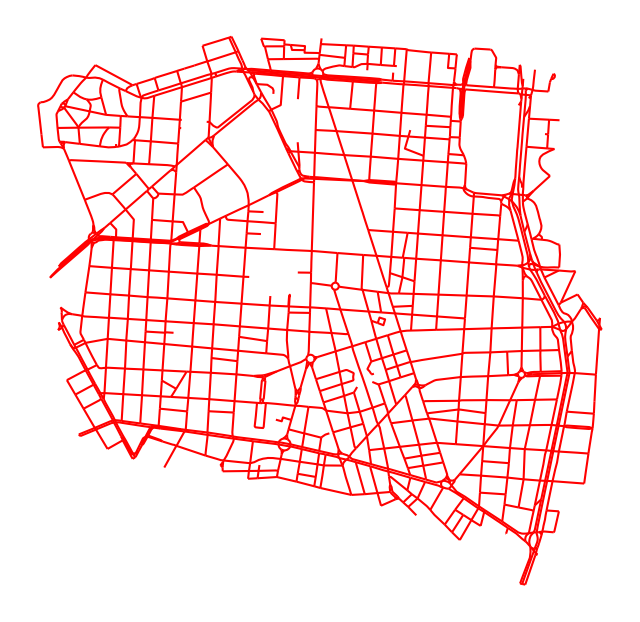

In [3]:
ax = edges.plot(figsize=(8, 12), color="red")
ax.set_axis_off()

## Default behavior

In [4]:
edges_output = mm.roundabout_simplification(edges)

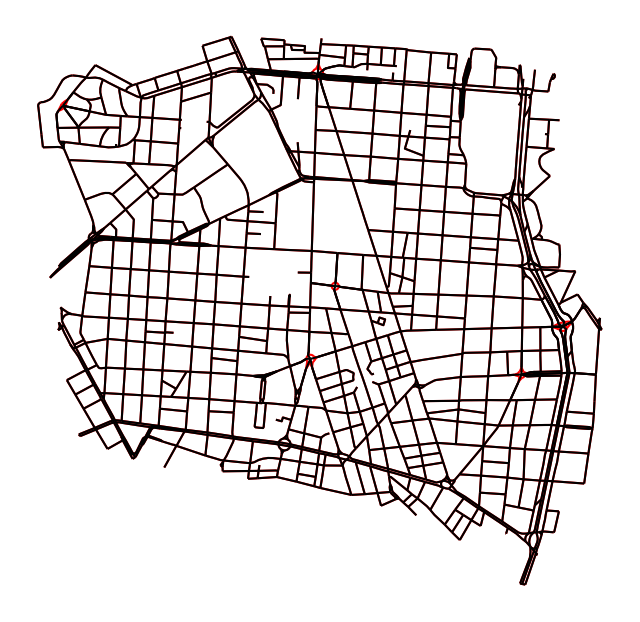

In [5]:
ax = edges.plot(figsize=(8, 12), color="red")
edges_output.plot(ax=ax, figsize=(8, 12), color="black")

ax.set_axis_off()

Using the output column `'simplification_group'` we can count the number of roundabouts that were simplified:

In [6]:
edges_output.simplification_group.nunique()

7

In total **7** roundabouts were simplified, and most of their incoming edges were also considered during the process. 

Let's look at them individually.

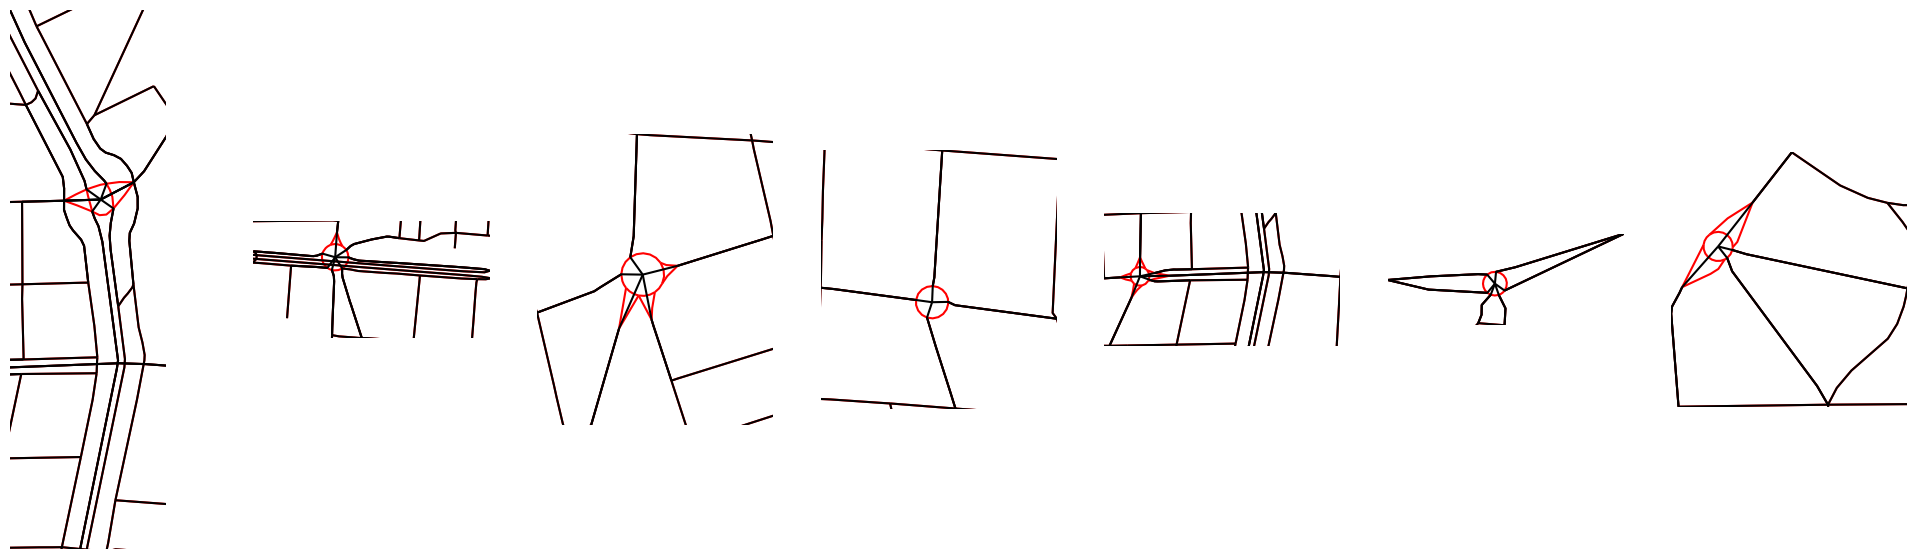

In [7]:
simplification_groups = edges_output.simplification_group.unique()[1:]

fig, axs = plt.subplots(1, len(simplification_groups), figsize=(25, 7))
axs = axs.flatten()

for i in simplification_groups:
    mask = edges_output.simplification_group == i
    minx, miny, maxx, maxy = edges_output[mask].geometry.total_bounds

    edges.plot(ax=axs[i], color="red")
    edges_output.plot(ax=axs[i], color="black")

    axs[i].set_xlim(minx, maxx)
    axs[i].set_ylim(miny, maxy)
    axs[i].set_axis_off()

plt.show()

It's worth investigating why some roundabouts are still missing from simplification. Since the selection of roundabouts is based on the resulting polygons after polygonizing the road network let's use the circular compactness (measurable as `momepy.CircularCompactness`) parameter of the resulting polygons as the main selection attribute.

In [8]:
from shapely.ops import polygonize

polys = gpd.GeoDataFrame(
    geometry=list(polygonize(edges.geometry)), crs=edges.crs
)
circom_serie = mm.CircularCompactness(polys).series
polys.loc[:, "circom"] = circom_serie

The `circom_threshold` parameter (default = 0.7) establishes the limit at which roundabouts should be selected.

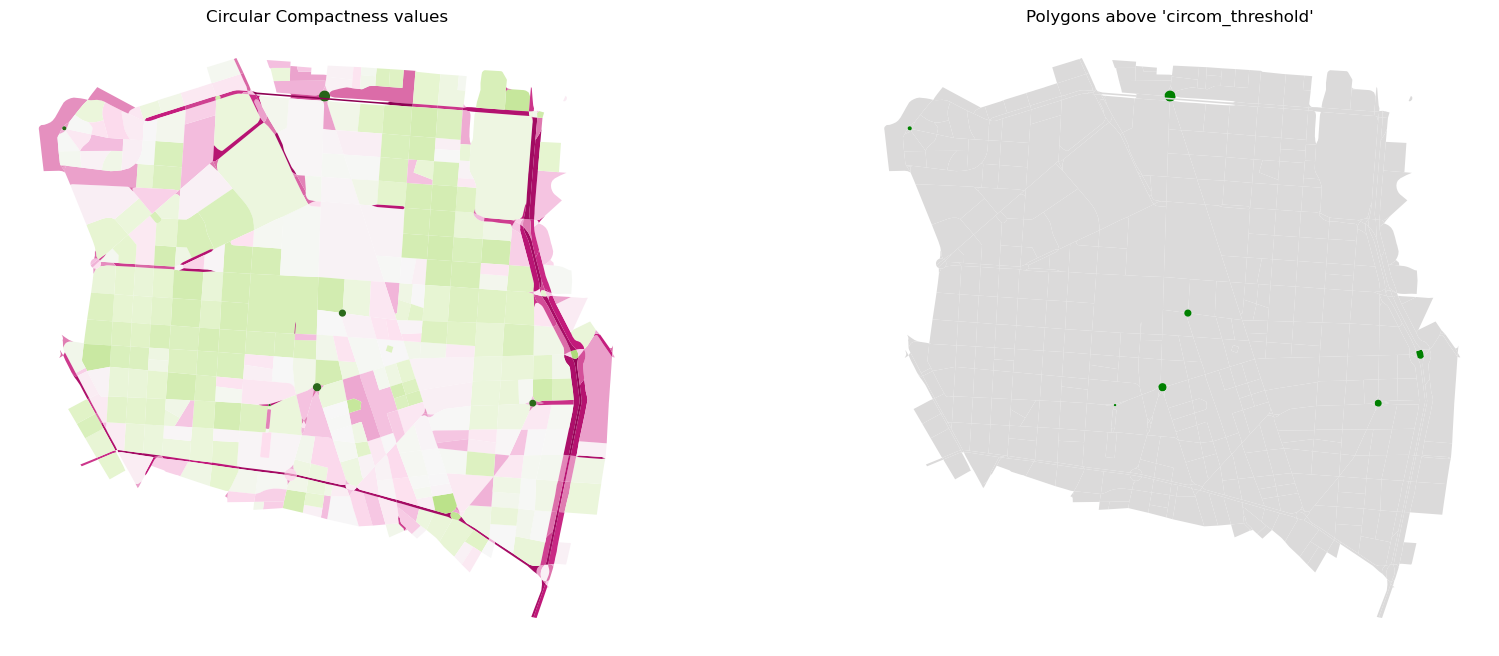

In [9]:
circom_threshold = 0.7
mask = circom_serie > circom_threshold
colors = ["green" if m else "#dbdada" for m in mask]

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

polys.plot(ax=axs[0], column="circom", cmap="PiYG")
axs[0].set_axis_off()
axs[0].title.set_text("Circular Compactness values")

polys.plot(ax=axs[1], color=colors)
axs[1].set_axis_off()
axs[1].title.set_text("Polygons above 'circom_threshold' ")

Let's see the following two **false negatives**:

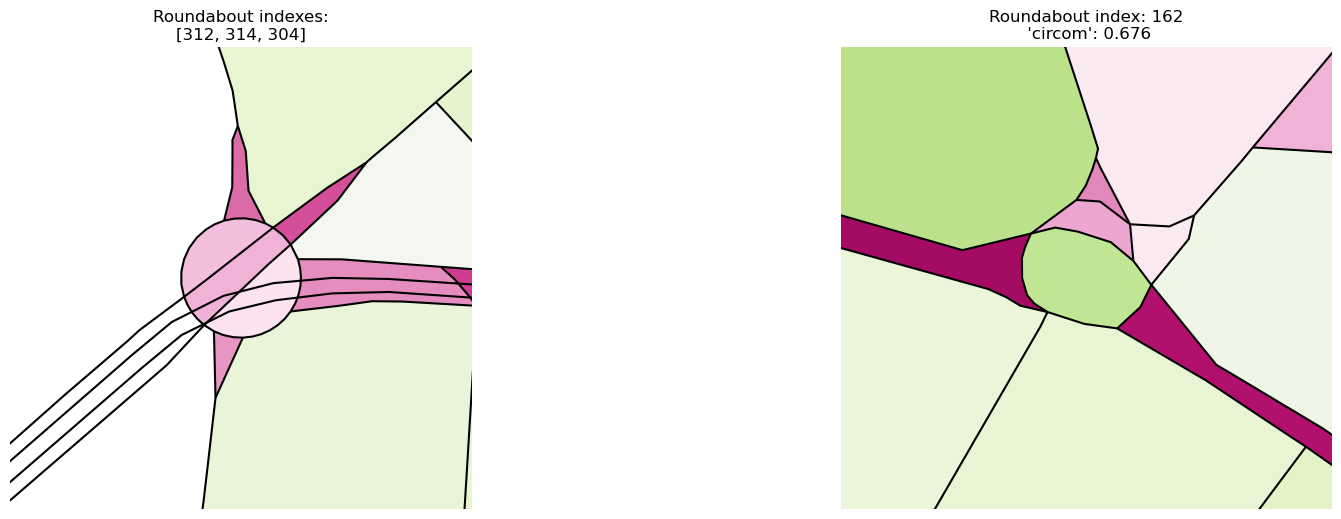

In [10]:
false_negatives = [[312, 314, 304], 162]


fig, axs = plt.subplots(1, 2, figsize=(20, 6))


edges.plot(ax=axs[0], color="black")
polys.plot(ax=axs[0], column="circom", cmap="PiYG")
minx, miny, maxx, maxy = polys.loc[false_negatives[0]].geometry.total_bounds
axs[0].set_xlim(minx - 75, maxx + 75)
axs[0].set_ylim(miny - 75, maxy + 75)
axs[0].set_axis_off()
axs[0].title.set_text("Roundabout indexes:\n" + str(false_negatives[0]))

edges.plot(ax=axs[1], color="black")
polys.plot(ax=axs[1], column="circom", cmap="PiYG")
minx, miny, maxx, maxy = polys.loc[false_negatives[1]].geometry.bounds
label_str = str(round(polys.loc[false_negatives[1]].circom, 3))

axs[1].set_xlim(minx - 75, maxx + 75)
axs[1].set_ylim(miny - 75, maxy + 75)
axs[1].set_axis_off()
axs[1].title.set_text("Roundabout index: 162\n 'circom': " + label_str)

The above helps to exemplify two main reasons why some roundabouts are not being selected:
1. They are crossed by other roads; which breaks them into multiple polygons
    - eg. `index`: `[314, 312, 304]`
1. They don't meet the `circom_threshold`
     - eg. `index`: `[162]` --> (0.676) 
     
## Adapting parameters
Finally, let's also explore what the outcome would look like if we lower the `circom_threshold` and `include_adjacent` is set to `False` 

In [11]:
edges_output_65 = mm.roundabout_simplification(
    edges, circom_threshold=0.65, include_adjacent=False
)

m = edges.explore(color="black", tiles="CartoDB positron")
edges_output.explore(m=m, color="red")
edges_output_65.explore(m=m, color="blue")
m

In [12]:
edges_output_65.simplification_group.nunique()

12

Even though we have been able to simplify **13** supposedly polygons, this sample now contains some false positives. So it is up to the user to decide the right balance to make the most of this simplification.

Note that this is a work in progress and some upcoming enhancements are expected to complement this simplification.